In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams

from methods import Hexagon, HexagonalGCs, permutation_test
from models import Similitude
from plotting_functions import scatter3d

In [78]:
# load trained model
model = torch.load('./saved-models/Similitude2-14-dirac')

# ---> OVERLOAD/PRUNE/ABLATE PHASES <---
# random uniform
#phases = model.unit_cell.sample(6)
#phases = np.random.uniform(0,0.2,size=model.phases.shape)
#model.phases = torch.nn.Parameter(torch.tensor(phases,dtype=torch.float32))
#mask = torch.linalg.norm(model.phases+0.2,axis=-1) > 0.4
#model.phases = torch.nn.Parameter(model.phases[mask])
# ---

if False:
    # Overwrite Initial Phase Placements
    start_phases = model.unit_cell.sample(4)
    model.set_phases(start_phases)

phases = model.phases.clone().detach().numpy()
wrapped_phases = model.unit_cell.wrap(phases)

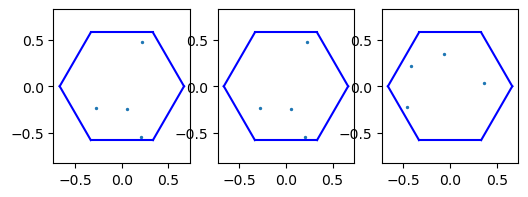

In [79]:
fig, axs = plt.subplots(ncols=3,figsize=(3*2,2))
axs[0].scatter(*phases.T,s=2)
axs[1].scatter(*wrapped_phases.T,s=2)
axs[2].scatter(*model.unit_cell.sample(phases.shape[0]).T,s=2)
[axs[i].axis('equal') for i in range(len(axs))]

[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]
fig.subplots_adjust(wspace=0.2)

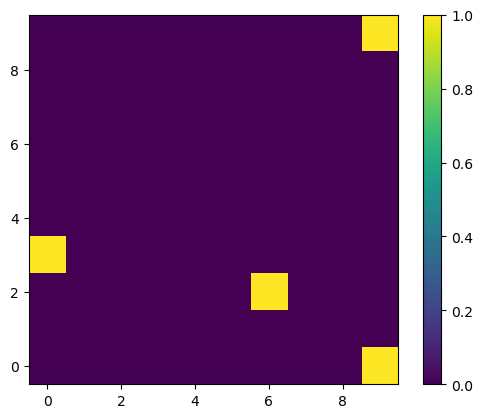

In [80]:
hist2d = scipy.stats.binned_statistic_2d(*wrapped_phases.T,None,statistic='count').statistic
plt.imshow(hist2d.T,origin='lower')
plt.colorbar()

### Test (Linear) decoding performance

In [81]:
def test_decoding(model,nsamples_space=10000):
    r = model.unit_cell.sample(nsamples_space)
    activity = model.forward(torch.tensor(r,dtype=torch.float32))
    model.train_decoder(torch.tensor(r,dtype=torch.float32),bias=True)
    r_pred = model.decode(activity)
    r_pred = r_pred.detach().numpy()
    r_wrapped = model.unit_cell.wrap(r_pred)
    return r, r_pred, model.unit_cell.geodesic(r,r_wrapped), np.linalg.norm(r-r_wrapped,axis=-1)

0.27968702463827666 0.284831269748715


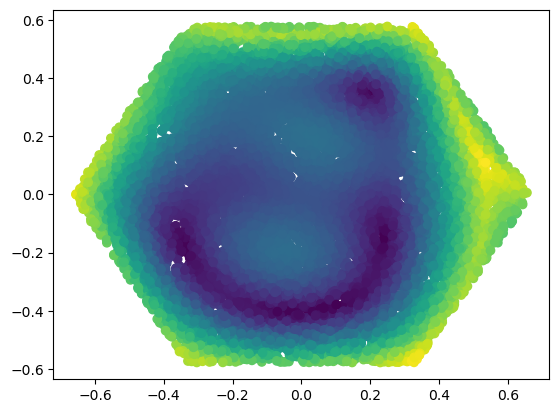

In [82]:
r, r_pred, decoding_error, decoding_error_euclidean = test_decoding(model)
print(np.mean(decoding_error), np.mean(decoding_error_euclidean))
sc = plt.scatter(*r.T,c=decoding_error)
#plt.colorbar(sc)

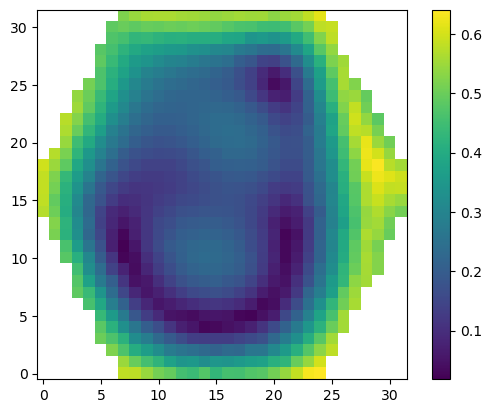

In [83]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,decoding_error,bins=32).statistic
plt.imshow(hist2d.T,origin='lower')
plt.colorbar()

### Activity Distance

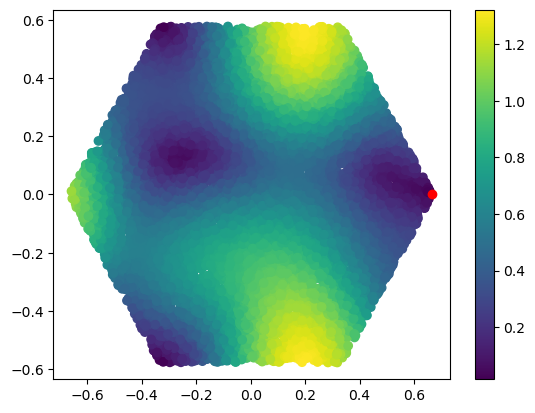

In [84]:
rs = model.unit_cell.sample(10000)
activity = model(torch.tensor(rs,dtype=torch.float32)).detach().numpy()
center = model.unit_cell.hpoints[:1]#model.unit_cell.center[None]
center_activity = model(torch.tensor(center,dtype=torch.float32)).detach().numpy()
sc = plt.scatter(*rs.T,c=np.linalg.norm(activity-center_activity,axis=-1))
plt.colorbar(sc)
plt.scatter(*center.T,color='red')

### Show The Jacobian

In [85]:
def test_detJ(model,nsamples_space=10000):
    r = model.unit_cell.sample(nsamples_space)
    J = model.jacobian(torch.tensor(r,dtype=torch.float32))
    det_J = model.the_jacobian(J)
    return r,det_J.detach().numpy()

In [86]:
r,detJ = test_detJ(model)

4.7885714


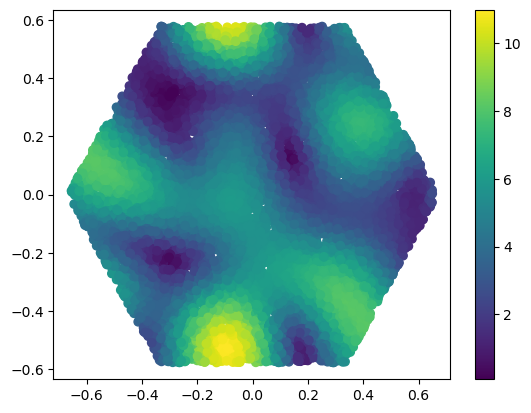

In [87]:
sc = plt.scatter(*r.T,c=detJ)
print(np.var(detJ))
plt.colorbar(sc)

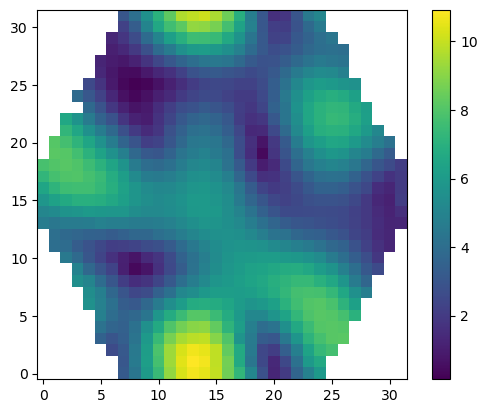

In [88]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,detJ,bins=32).statistic
plt.imshow(hist2d.T,origin='lower')
plt.colorbar()

### Show (low-dimensional projection) manifold

In [89]:
def show_manifold(model,nsamples_space=10000):
    #r = np.random.uniform(-1.2/2,1.2/2,size=(64**2,2))
    #r = model.unit_cell.sample(nsamples_space)
    #r = create_board(1.2,to_torch_tensor=False).reshape(-1,2)
    #r = r[model.unit_cell.is_in_hexagon(r)]
    r = model.unit_cell.mesh(60)
    activity = model.forward(torch.tensor(r,dtype=torch.float32)).detach().numpy()
    J = model.jacobian(torch.tensor(r,dtype=torch.float32))
    detJ = model.the_jacobian(J).detach().numpy()
    projection = umap.UMAP(n_neighbors=100,n_components=3)
    return projection.fit_transform(activity), projection, activity, detJ

In [90]:
manifold, projection, activity, detJ = show_manifold(model)
# SHOULD PUT ABSOLUTE COLOR SCALING WRT HIGHEST AND LOWEST OF RELEVANT MODELS
detJ = detJ-np.min(detJ)
detJ = detJ/np.max(detJ)

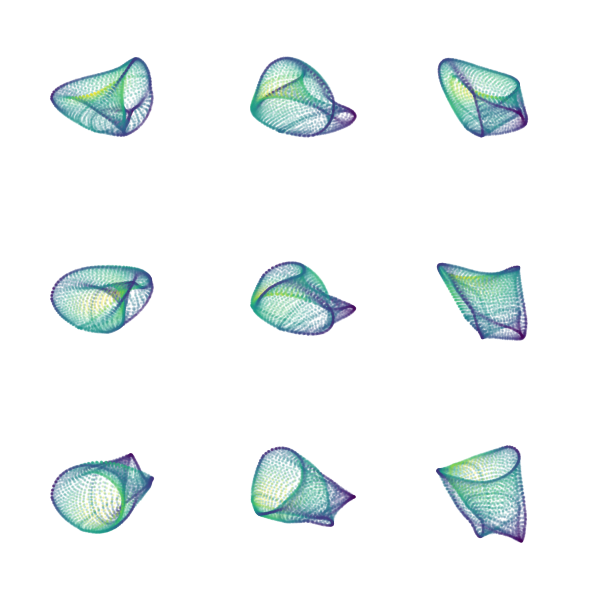

In [91]:
fig, axs = scatter3d(manifold,ncols=3,nrows=3,azim_elev_title=False,figsize=(6,6),alpha=0.2,c=detJ);
#fig.subplots_adjust(hspace=0,wspace=0)
plt.tight_layout()

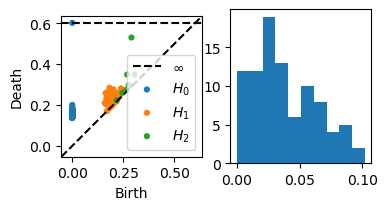

In [92]:
fig,axs = plt.subplots(ncols=2,figsize=(4,2))
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0]);

### Test whether distribution is uniform

In [56]:
def ripleys_choose_radius(radius,unit_cell):
    return lambda X,Y: unit_cell.ripleys(X,radius,geometric_enclosure="hexagons") - unit_cell.ripleys(Y,radius,geometric_enclosure="hexagons")

In [19]:
random_uniform_phases = model.unit_cell.sample(phases.shape[0])

In [20]:
radii = np.linspace(0,model.unit_cell.radius,11)[1:]
nperms = 100
stats,ps,H0s = [],[],[]
for radius in radii:
    ripleys_statistic = ripleys_choose_radius(radius,model.unit_cell)
    #stat, p, H0 = permutation_test(wrapped_phases,random_uniform_phases,
    #                               ripleys_statistic,nperms=nperms,alternative='greater')
    stat, p, H0 = permutation_test(wrapped_phases,model.unit_cell.sample,
                                   ripleys_statistic,nperms=nperms,alternative='greater')
    stats.append(stat)
    ps.append(p)
    H0s.append(H0)
stats,ps,H0s = np.array(stats), np.array(ps), np.array(H0s)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 724.31it/s]


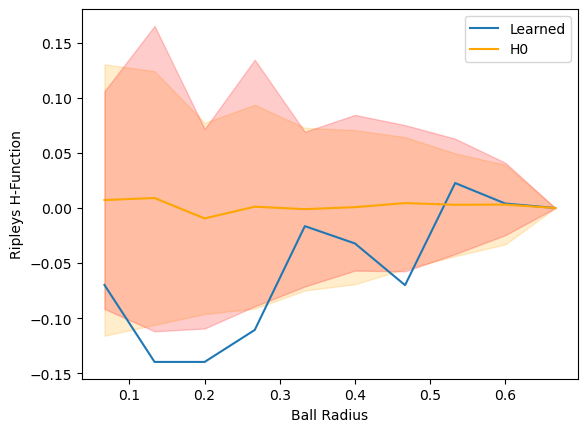

In [21]:
plt.plot(radii,stats,label='Learned')
# u +- 2sigma (Normal assumption)
mu0 = np.mean(H0s,axis=-1)
s0 = np.std(H0s,axis=-1)
plt.plot(radii,mu0,label='H0',color='orange')
plt.fill_between(radii,mu0-2*s0,mu0+2*s0,alpha=0.2,color='orange')
# Empirical Confidence interval
H0s_sorted = np.sort(H0s)
ci_fraction = 0.95
percentile = (1-ci_fraction)/2
ci_idx_lower = int(percentile*nperms)
lower = H0s_sorted[:,ci_idx_lower]
upper = H0s_sorted[:,nperms-ci_idx_lower]
plt.fill_between(radii,mu0-abs(lower),mu0+abs(upper),alpha=0.2,color='red')
plt.xlabel('Ball Radius')
plt.ylabel('Ripleys H-Function')
plt.legend()

[0.01980198 0.01980198 0.00990099 0.02970297]


Text(0, 0.5, 'P-value')

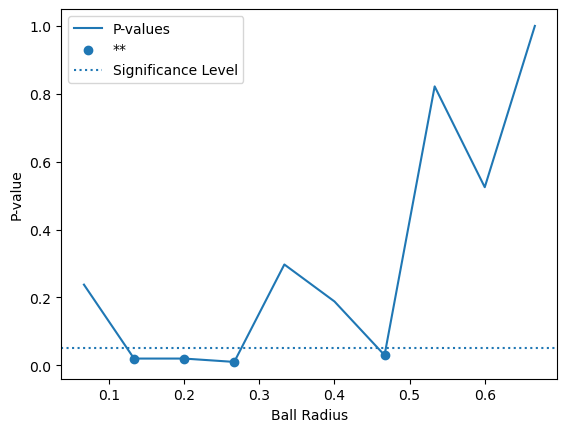

In [22]:
# should correct significance level based on number of tests
significance=0.05
plt.plot(radii,ps,label='P-values')
mask = ps < significance
print(ps[mask])
plt.scatter(radii[mask],ps[mask],label='**')
plt.axhline(significance,ls=':',label='Significance Level')
plt.legend()
plt.xlabel('Ball Radius')
plt.ylabel('P-value')

In [23]:
ripley_mesh, ripley_learned, ripley_sample = [], [], []
geometric_enclosure="hyperballs"
radii2 = np.linspace(0,model.unit_cell.radius,200)[1:]
for radius in tqdm.tqdm(radii2):
    ripley_mesh.append(model.unit_cell.ripleys(model.unit_cell.mesh(int(np.sqrt(model.ncells))),radius,geometric_enclosure=geometric_enclosure))
    ripley_learned.append(model.unit_cell.ripleys(wrapped_phases,radius,geometric_enclosure=geometric_enclosure))
    ripley_sample.append(model.unit_cell.ripleys(model.unit_cell.sample(model.ncells),radius,geometric_enclosure=geometric_enclosure))

100%|████████████████████████████████████████| 199/199 [00:00<00:00, 438.54it/s]


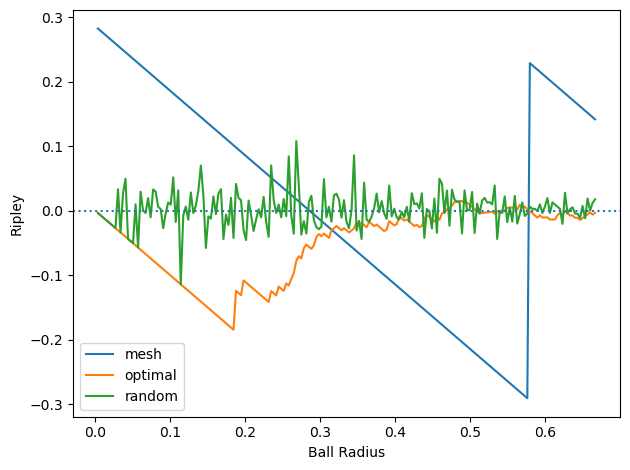

In [24]:
plt.plot(radii2,ripley_mesh,label='mesh')
plt.plot(radii2,ripley_learned,label='optimal')
plt.plot(radii2,ripley_sample,label='random')
plt.axhline(0,ls=':')
plt.xlabel('Ball Radius')
plt.ylabel('Ripley')
plt.legend()
plt.tight_layout()
plt.savefig("./test")